In [2]:
# Cature imge through webcam

import cv2

# Open the webcam video capture object
cap = cv2.VideoCapture(0)

# Define the video codec and output filename
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi', fourcc, 20.0, (640, 480))

while True:
    # Capture a frame from the webcam
    ret, frame = cap.read()

    # Check if frame is read correctly
    if not ret:
        break

    # Display the captured frame
    cv2.imshow('Webcam', frame)

    # Press 'q' to quit
    if cv2.waitKey(1) == ord('q'):
        break

    # Write the frame to the output video file
    out.write(frame)

# Release the capture object and video writer
cap.release()
out.release()
cv2.destroyAllWindows()



In [2]:
# Apply filter, Edge detection and canny edge detection 

import cv2
import sys
import numpy

PREVIEW  = 0  # Preview Mode
BLUR     = 1  # Blurring Filter
FEATURES = 2  # Corner Feature Detector
CANNY    = 3  # Canny Edge Detector

feature_params = dict(maxCorners=500, qualityLevel=0.2, minDistance=15, blockSize=9)
s = 0
if len(sys.argv) > 1:
    s = sys.argv[1]

image_filter = PREVIEW
alive = True

win_name = "Camera Filters"
cv2.namedWindow(win_name, cv2.WINDOW_NORMAL)
result = None

source = cv2.VideoCapture(0)

while alive:
    has_frame, frame = source.read()
    if not has_frame:
        break

    frame = cv2.flip(frame, 1)

    if image_filter == PREVIEW:
        result = frame
    elif image_filter == CANNY:
        result = cv2.Canny(frame, 140, 150)
    elif image_filter == BLUR:
        result = cv2.blur(frame, (13, 13))
    elif image_filter == FEATURES:
        result = frame
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        corners = cv2.goodFeaturesToTrack(frame_gray, **feature_params)
        if corners is not None:
             # Ensure corners are integers for circle function
            
            for x, y in numpy.int32(corners).reshape(-1, 2):
                cv2.circle(result, (x, y), 10, (0, 255, 0), 1)

    cv2.imshow(win_name, result)

    key = cv2.waitKey(1)
    if key == ord("Q") or key == ord("q") or key == 27:
        alive = False
    elif key == ord("C") or key == ord("c"):
        image_filter = CANNY
    elif key == ord("B") or key == ord("b"):
        image_filter = BLUR
    elif key == ord("F") or key == ord("f"):
        image_filter = FEATURES
    elif key == ord("P") or key == ord("p"):
        image_filter = PREVIEW

source.release()
cv2.destroyWindow(win_name)

Reading reference image: im1.jpg
Reading image to align: im2.jpg


Text(0.5, 1.0, 'Scanned Form')

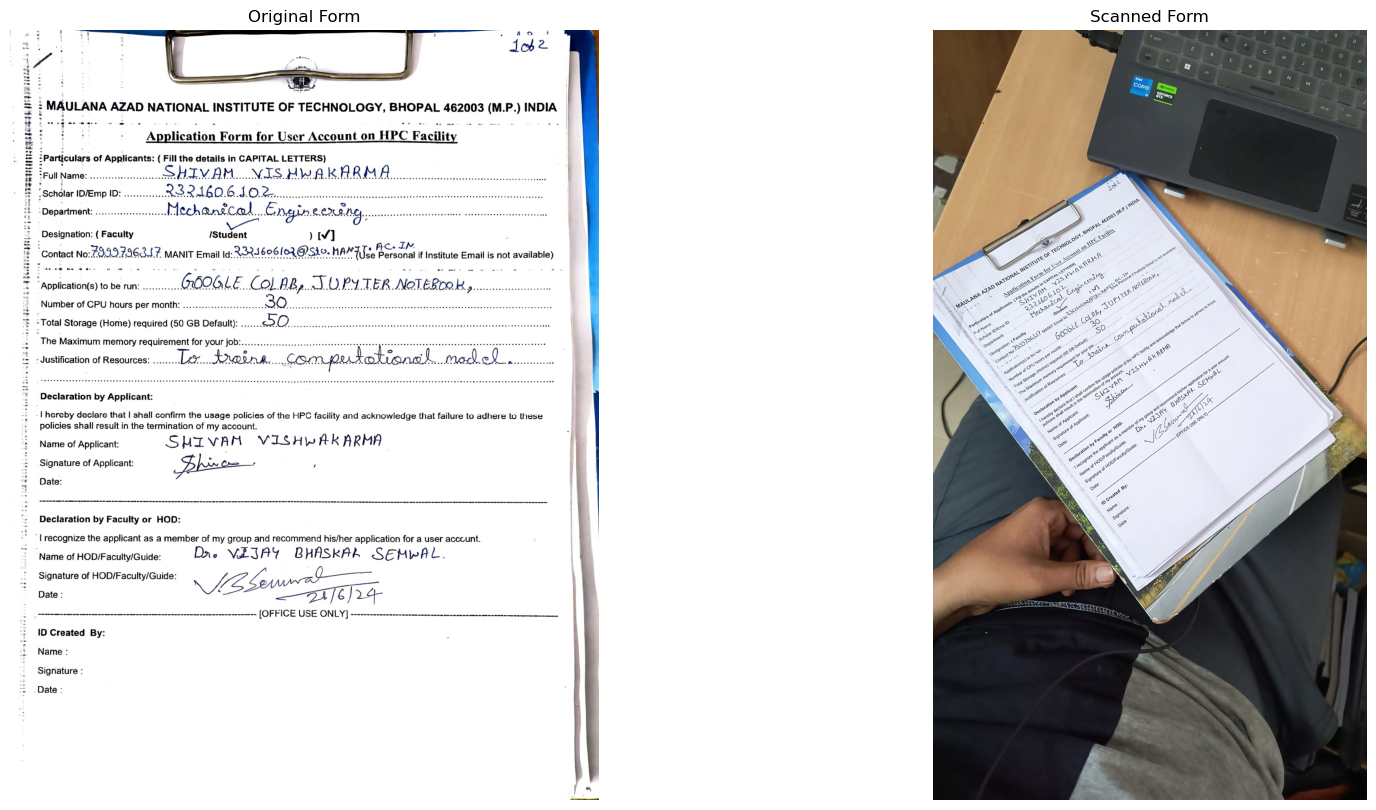

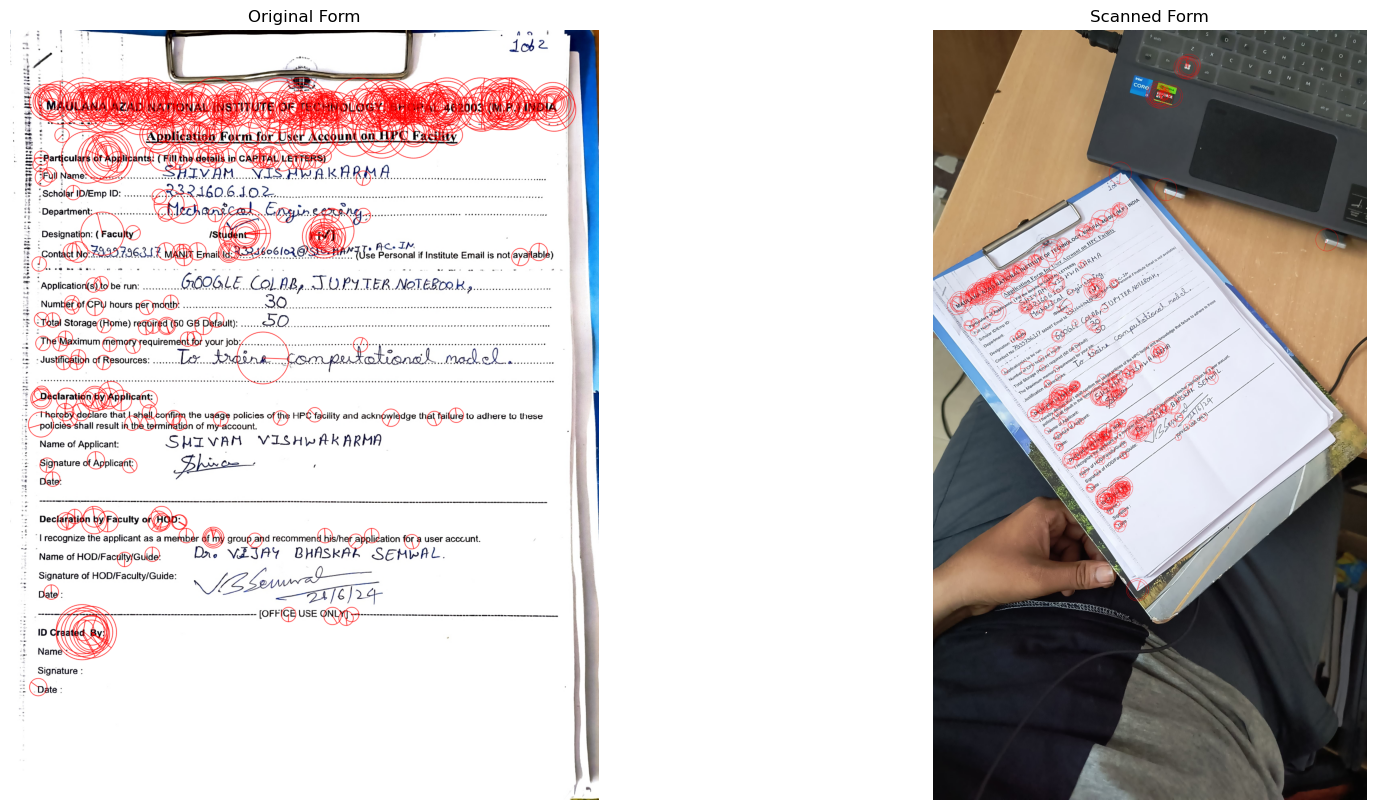

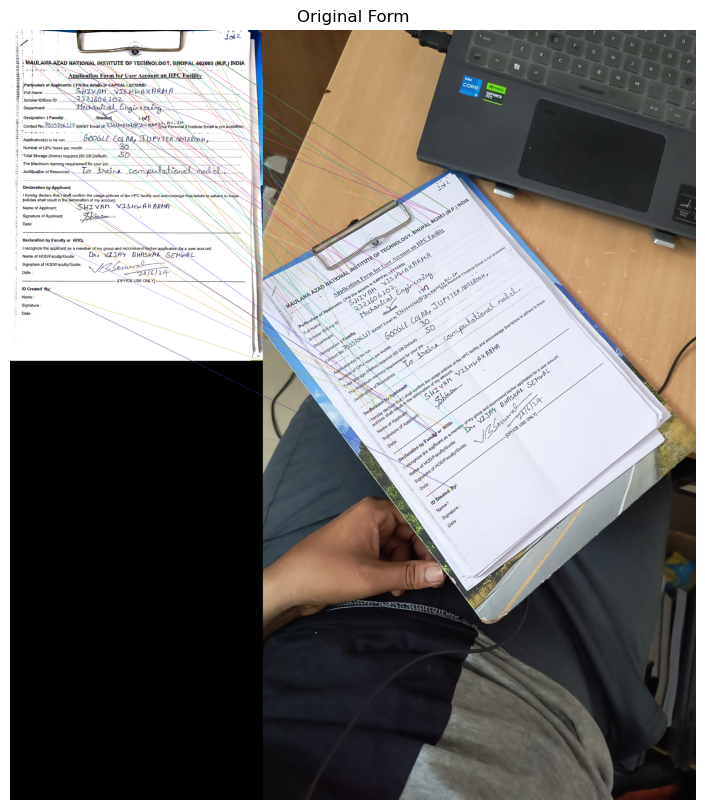

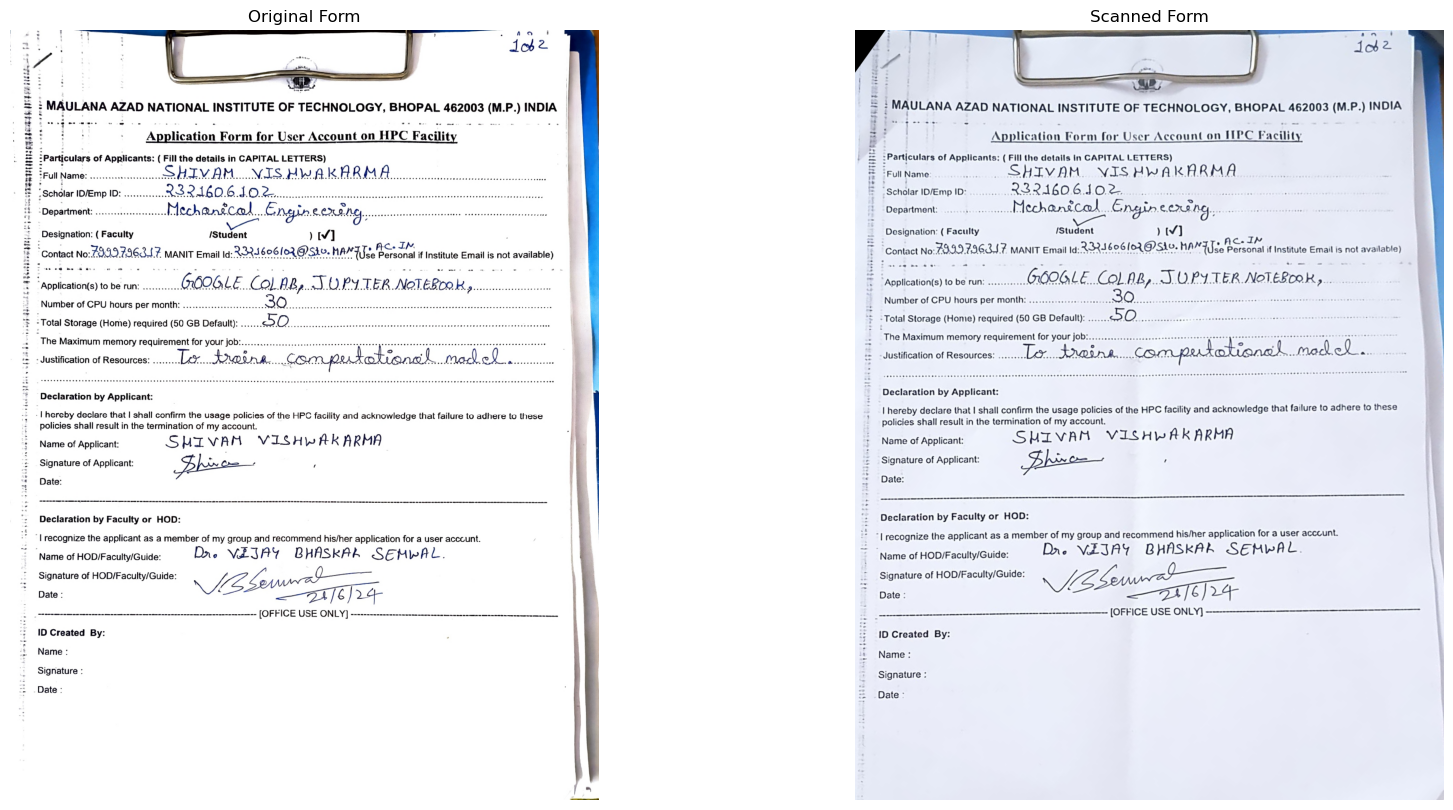

In [5]:
# Image Allignmet

# Imports
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from zipfile import ZipFile
from urllib.request import urlretrieve

%matplotlib inline

def download_and_unzip(url, save_path):
    print(f"Downloading and extracting assests....", end="")

    # Downloading zip file using urllib package.
    urlretrieve(url, save_path)

    try:
        # Extracting zip file using the zipfile package.
        with ZipFile(save_path) as z:
            # Extract ZIP file contents in the same directory.
            z.extractall(os.path.split(save_path)[0])

        print("Done")

    except Exception as e:
        print("\nInvalid file.", e)
        
URL = r"https://www.dropbox.com/s/zuwnn6rqe0f4zgh/opencv_bootcamp_assets_NB8.zip?dl=1"

asset_zip_path = os.path.join(os.getcwd(), f"opencv_bootcamp_assets_NB8.zip")

# Download if assest ZIP does not exists. 
if not os.path.exists(asset_zip_path):
    download_and_unzip(URL, asset_zip_path)
    
    
# Read reference image
refFilename = "im1.jpg"
print("Reading reference image:", refFilename)
im1 = cv2.imread(refFilename, cv2.IMREAD_COLOR)
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)

# Read image to be aligned
imFilename = "im2.jpg"
print("Reading image to align:", imFilename)
im2 = cv2.imread(imFilename, cv2.IMREAD_COLOR)
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)


# Display Images

plt.figure(figsize=[20, 10]); 
plt.subplot(121); plt.axis('off'); plt.imshow(im1); plt.title("Original Form")
plt.subplot(122); plt.axis('off'); plt.imshow(im2); plt.title("Scanned Form")

# Convert images to grayscale
im1_gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
im2_gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)


# Detect ORB features and compute descriptors.
MAX_NUM_FEATURES = 500
orb = cv2.ORB_create(MAX_NUM_FEATURES)
keypoints1, descriptors1 = orb.detectAndCompute(im1_gray, None)
keypoints2, descriptors2 = orb.detectAndCompute(im2_gray, None)

# Display
im1_display = cv2.drawKeypoints(im1, keypoints1, outImage=np.array([]), 
                                color=(255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

im2_display = cv2.drawKeypoints(im2, keypoints2, outImage=np.array([]), 
                                color=(255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=[20,10])
plt.subplot(121); plt.axis('off'); plt.imshow(im1_display); plt.title("Original Form");
plt.subplot(122); plt.axis('off'); plt.imshow(im2_display); plt.title("Scanned Form");

# Match features.
matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)

# Converting to list for sorting as tuples are immutable objects.
matches = list(matcher.match(descriptors1, descriptors2, None))

# Sort matches by score
matches.sort(key=lambda x: x.distance, reverse=False)

# Remove not so good matches
numGoodMatches = int(len(matches) * 0.1)
matches = matches[:numGoodMatches]

# Draw top matches
im_matches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)

plt.figure(figsize=[40, 10])
plt.imshow(im_matches);plt.axis("off");plt.title("Original Form")

# Extract location of good matches
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

for i, match in enumerate(matches):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt

# Find homography
h, mask = cv2.findHomography(points2, points1, cv2.RANSAC)

# Use homography to warp image
height, width, channels = im1.shape
im2_reg = cv2.warpPerspective(im2, h, (width, height))

# Display results
plt.figure(figsize=[20, 10])
plt.subplot(121);plt.imshow(im1);    plt.axis("off");plt.title("Original Form")
plt.subplot(122);plt.imshow(im2_reg);plt.axis("off");plt.title("Scanned Form")
